# Risk Parity Portfolio Optimization

## Introduction

Risk parity is a portfolio allocation strategy that focuses on equalizing the risk contributions of each asset in the portfolio, rather than equalizing capital allocation. This approach was popularized by Bridgewater Associates and has become a cornerstone of modern portfolio theory.

## Theoretical Foundation

### Portfolio Risk Decomposition

Consider a portfolio with $n$ assets and weight vector $\mathbf{w} = (w_1, w_2, \ldots, w_n)^T$. The portfolio variance is given by:

$$\sigma_p^2 = \mathbf{w}^T \boldsymbol{\Sigma} \mathbf{w}$$

where $\boldsymbol{\Sigma}$ is the covariance matrix of asset returns.

### Marginal Risk Contribution

The marginal risk contribution (MRC) of asset $i$ is defined as the partial derivative of portfolio volatility with respect to weight $w_i$:

$$\text{MRC}_i = \frac{\partial \sigma_p}{\partial w_i} = \frac{(\boldsymbol{\Sigma} \mathbf{w})_i}{\sigma_p}$$

### Total Risk Contribution

The total risk contribution (TRC) of asset $i$ is:

$$\text{TRC}_i = w_i \cdot \text{MRC}_i = \frac{w_i (\boldsymbol{\Sigma} \mathbf{w})_i}{\sigma_p}$$

By Euler's theorem for homogeneous functions, the sum of all TRCs equals the total portfolio volatility:

$$\sum_{i=1}^{n} \text{TRC}_i = \sigma_p$$

### Risk Parity Condition

The risk parity portfolio requires that all assets contribute equally to total portfolio risk:

$$\text{TRC}_i = \text{TRC}_j \quad \forall \, i, j$$

This can be expressed as:

$$w_i (\boldsymbol{\Sigma} \mathbf{w})_i = w_j (\boldsymbol{\Sigma} \mathbf{w})_j \quad \forall \, i, j$$

### Optimization Formulation

The risk parity problem can be formulated as minimizing the sum of squared differences in risk contributions:

$$\min_{\mathbf{w}} \sum_{i=1}^{n} \sum_{j=1}^{n} \left( w_i (\boldsymbol{\Sigma} \mathbf{w})_i - w_j (\boldsymbol{\Sigma} \mathbf{w})_j \right)^2$$

subject to:
$$\sum_{i=1}^{n} w_i = 1, \quad w_i \geq 0 \quad \forall \, i$$

## Implementation

We will implement the risk parity optimization using numerical methods and compare it with equal-weight and minimum-variance portfolios.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Set random seed for reproducibility
np.random.seed(42)

# Define asset parameters (annualized)
asset_names = ['Equities', 'Bonds', 'Commodities', 'Real Estate']
n_assets = len(asset_names)

# Expected returns (annualized)
expected_returns = np.array([0.08, 0.03, 0.05, 0.06])

# Volatilities (annualized)
volatilities = np.array([0.18, 0.05, 0.22, 0.14])

# Correlation matrix
correlation_matrix = np.array([
    [1.00, 0.10, 0.30, 0.50],
    [0.10, 1.00, 0.05, 0.15],
    [0.30, 0.05, 1.00, 0.25],
    [0.50, 0.15, 0.25, 1.00]
])

# Construct covariance matrix
D = np.diag(volatilities)
covariance_matrix = D @ correlation_matrix @ D

print("Asset Characteristics:")
print("-" * 50)
for i, name in enumerate(asset_names):
    print(f"{name}: Return = {expected_returns[i]*100:.1f}%, Volatility = {volatilities[i]*100:.1f}%")

print("\nCovariance Matrix:")
print(pd.DataFrame(covariance_matrix, index=asset_names, columns=asset_names).round(4))

Asset Characteristics:
--------------------------------------------------
Equities: Return = 8.0%, Volatility = 18.0%
Bonds: Return = 3.0%, Volatility = 5.0%
Commodities: Return = 5.0%, Volatility = 22.0%
Real Estate: Return = 6.0%, Volatility = 14.0%

Covariance Matrix:
             Equities   Bonds  Commodities  Real Estate
Equities       0.0324  0.0009       0.0119       0.0126
Bonds          0.0009  0.0025       0.0006       0.0011
Commodities    0.0119  0.0006       0.0484       0.0077
Real Estate    0.0126  0.0011       0.0077       0.0196


In [2]:
def portfolio_volatility(weights, cov_matrix):
    """Calculate portfolio volatility."""
    return np.sqrt(weights.T @ cov_matrix @ weights)

def portfolio_return(weights, exp_returns):
    """Calculate expected portfolio return."""
    return weights.T @ exp_returns

def risk_contribution(weights, cov_matrix):
    """Calculate the risk contribution of each asset."""
    port_vol = portfolio_volatility(weights, cov_matrix)
    marginal_risk = (cov_matrix @ weights) / port_vol
    total_risk_contribution = weights * marginal_risk
    return total_risk_contribution

def risk_parity_objective(weights, cov_matrix):
    """Objective function: minimize squared differences in risk contributions."""
    rc = risk_contribution(weights, cov_matrix)
    target_rc = np.sum(rc) / len(rc)  # Equal risk contribution
    return np.sum((rc - target_rc) ** 2)

def get_risk_parity_weights(cov_matrix, n_assets):
    """Solve for risk parity portfolio weights."""
    # Initial guess: equal weights
    x0 = np.ones(n_assets) / n_assets
    
    # Constraints
    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}  # Weights sum to 1
    ]
    
    # Bounds: weights between 0 and 1
    bounds = tuple((0.01, 1) for _ in range(n_assets))
    
    # Optimize
    result = minimize(
        risk_parity_objective,
        x0,
        args=(cov_matrix,),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        options={'ftol': 1e-12, 'maxiter': 1000}
    )
    
    return result.x

def get_min_variance_weights(cov_matrix, n_assets):
    """Solve for minimum variance portfolio weights."""
    x0 = np.ones(n_assets) / n_assets
    
    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    ]
    
    bounds = tuple((0, 1) for _ in range(n_assets))
    
    result = minimize(
        lambda w: portfolio_volatility(w, cov_matrix),
        x0,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    
    return result.x

In [3]:
# Calculate portfolio weights for different strategies

# 1. Equal Weight Portfolio
equal_weights = np.ones(n_assets) / n_assets

# 2. Risk Parity Portfolio
risk_parity_weights = get_risk_parity_weights(covariance_matrix, n_assets)

# 3. Minimum Variance Portfolio
min_var_weights = get_min_variance_weights(covariance_matrix, n_assets)

# Create results dataframe
weights_df = pd.DataFrame({
    'Equal Weight': equal_weights,
    'Risk Parity': risk_parity_weights,
    'Min Variance': min_var_weights
}, index=asset_names)

print("Portfolio Weights:")
print("=" * 60)
print(weights_df.round(4))
print("\nSum of weights:")
print(weights_df.sum().round(4))

Portfolio Weights:
             Equal Weight  Risk Parity  Min Variance
Equities             0.25       0.1294        0.0187
Bonds                0.25       0.5852        0.9067
Commodities          0.25       0.1194        0.0258
Real Estate          0.25       0.1659        0.0489

Sum of weights:
Equal Weight    1.0
Risk Parity     1.0
Min Variance    1.0
dtype: float64


In [4]:
# Calculate risk contributions for each portfolio

def analyze_portfolio(weights, name, cov_matrix, exp_returns):
    """Analyze and display portfolio characteristics."""
    vol = portfolio_volatility(weights, cov_matrix)
    ret = portfolio_return(weights, exp_returns)
    rc = risk_contribution(weights, cov_matrix)
    rc_pct = rc / vol * 100
    sharpe = ret / vol  # Assuming risk-free rate = 0
    
    return {
        'name': name,
        'return': ret,
        'volatility': vol,
        'sharpe': sharpe,
        'risk_contribution': rc,
        'risk_contribution_pct': rc_pct
    }

# Analyze all portfolios
portfolios = [
    analyze_portfolio(equal_weights, 'Equal Weight', covariance_matrix, expected_returns),
    analyze_portfolio(risk_parity_weights, 'Risk Parity', covariance_matrix, expected_returns),
    analyze_portfolio(min_var_weights, 'Min Variance', covariance_matrix, expected_returns)
]

# Display results
print("Portfolio Performance Summary:")
print("=" * 60)
for p in portfolios:
    print(f"\n{p['name']}:")
    print(f"  Expected Return: {p['return']*100:.2f}%")
    print(f"  Volatility: {p['volatility']*100:.2f}%")
    print(f"  Sharpe Ratio: {p['sharpe']:.3f}")

Portfolio Performance Summary:

Equal Weight:
  Expected Return: 5.50%
  Volatility: 10.38%
  Sharpe Ratio: 0.530

Risk Parity:
  Expected Return: 4.38%
  Volatility: 6.53%
  Sharpe Ratio: 0.672

Min Variance:
  Expected Return: 3.29%
  Volatility: 4.85%
  Sharpe Ratio: 0.679


In [5]:
# Display risk contributions
print("\nRisk Contributions (% of total portfolio risk):")
print("=" * 60)

rc_df = pd.DataFrame({
    p['name']: p['risk_contribution_pct'] for p in portfolios
}, index=asset_names)

print(rc_df.round(2))
print("\nSum of risk contributions:")
print(rc_df.sum().round(2))


Risk Contributions (% of total portfolio risk):
             Equal Weight  Risk Parity  Min Variance
Equities            33.54         25.0          1.86
Bonds                2.90         25.0         90.69
Commodities         39.78         25.0          2.57
Real Estate         23.77         25.0          4.88

Sum of risk contributions:
Equal Weight    100.0
Risk Parity     100.0
Min Variance    100.0
dtype: float64


/tmp/ipykernel_161096/2011457333.py:57: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax3.scatter(volatilities[i]*100, expected_returns[i]*100,


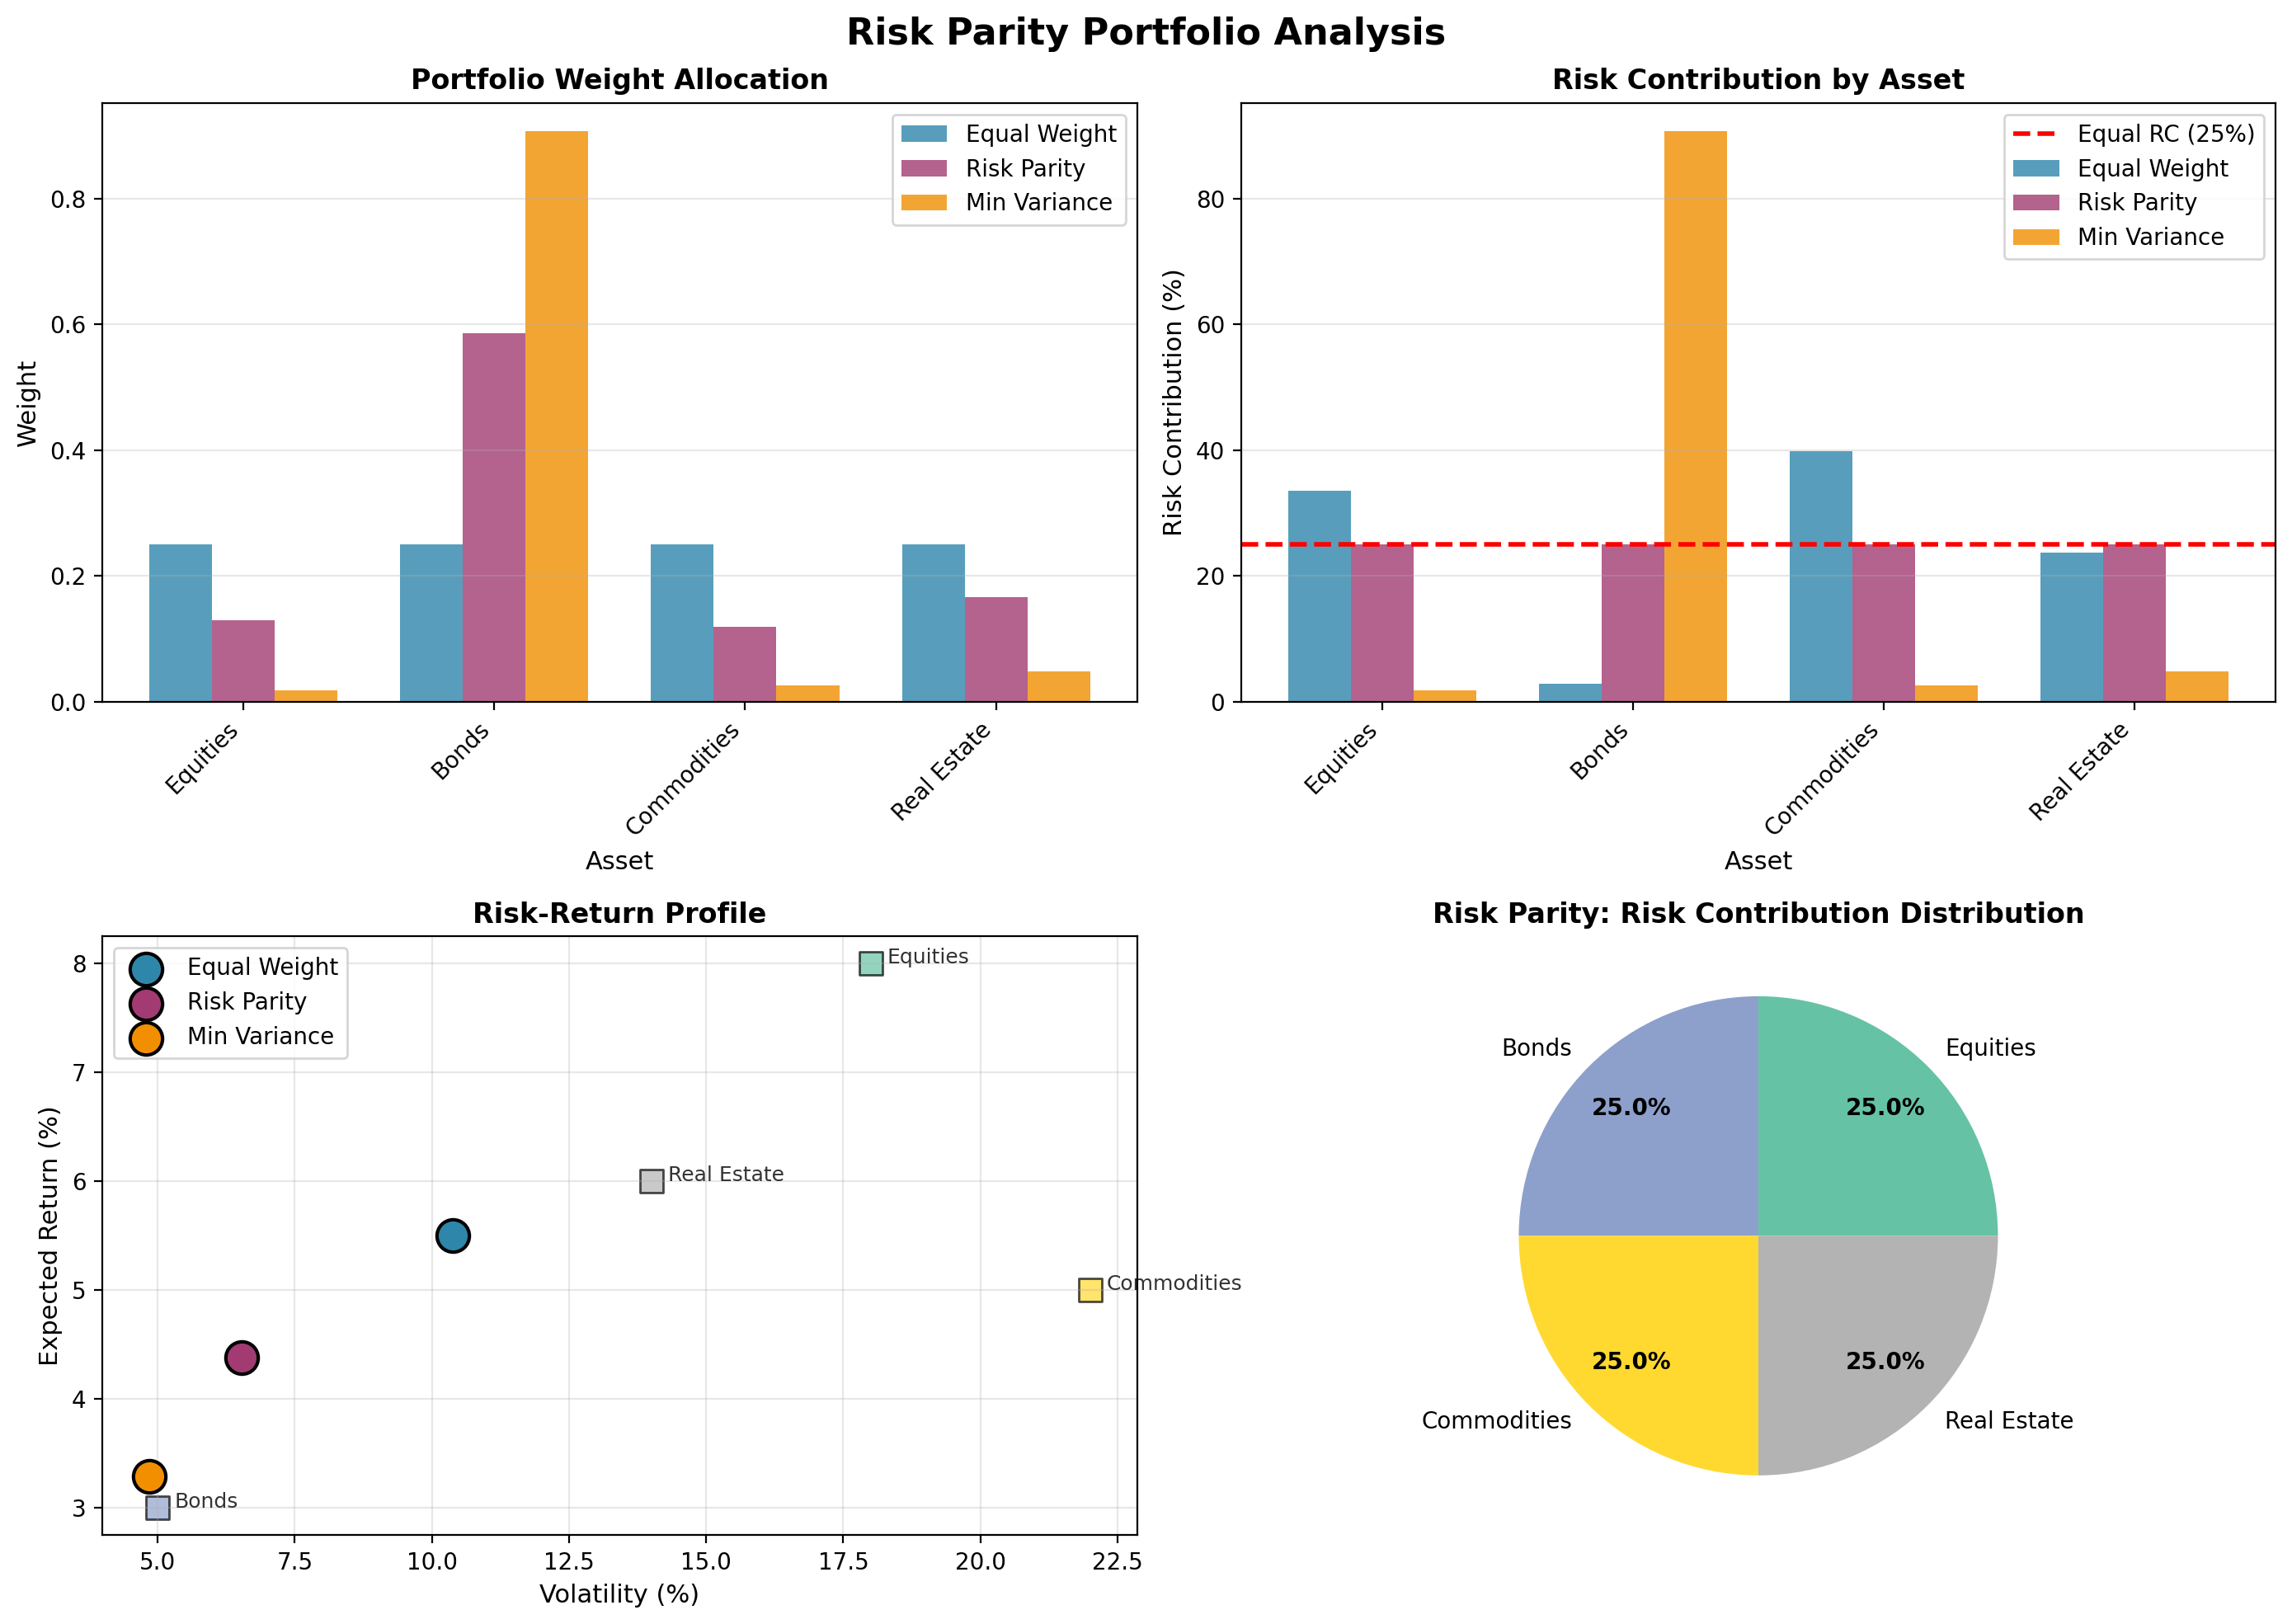


Plot saved to 'plot.png'


In [6]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Risk Parity Portfolio Analysis', fontsize=16, fontweight='bold')

colors = plt.cm.Set2(np.linspace(0, 1, n_assets))
portfolio_colors = ['#2E86AB', '#A23B72', '#F18F01']

# Plot 1: Portfolio Weights Comparison
ax1 = axes[0, 0]
x = np.arange(len(asset_names))
width = 0.25

bars1 = ax1.bar(x - width, equal_weights, width, label='Equal Weight', color=portfolio_colors[0], alpha=0.8)
bars2 = ax1.bar(x, risk_parity_weights, width, label='Risk Parity', color=portfolio_colors[1], alpha=0.8)
bars3 = ax1.bar(x + width, min_var_weights, width, label='Min Variance', color=portfolio_colors[2], alpha=0.8)

ax1.set_xlabel('Asset', fontsize=11)
ax1.set_ylabel('Weight', fontsize=11)
ax1.set_title('Portfolio Weight Allocation', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(asset_names, rotation=45, ha='right')
ax1.legend(loc='upper right')
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Risk Contributions
ax2 = axes[0, 1]

rc_equal = portfolios[0]['risk_contribution_pct']
rc_rp = portfolios[1]['risk_contribution_pct']
rc_mv = portfolios[2]['risk_contribution_pct']

bars1 = ax2.bar(x - width, rc_equal, width, label='Equal Weight', color=portfolio_colors[0], alpha=0.8)
bars2 = ax2.bar(x, rc_rp, width, label='Risk Parity', color=portfolio_colors[1], alpha=0.8)
bars3 = ax2.bar(x + width, rc_mv, width, label='Min Variance', color=portfolio_colors[2], alpha=0.8)

# Add horizontal line at 25% (equal risk contribution)
ax2.axhline(y=25, color='red', linestyle='--', linewidth=2, label='Equal RC (25%)')

ax2.set_xlabel('Asset', fontsize=11)
ax2.set_ylabel('Risk Contribution (%)', fontsize=11)
ax2.set_title('Risk Contribution by Asset', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(asset_names, rotation=45, ha='right')
ax2.legend(loc='upper right')
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Risk-Return Scatter
ax3 = axes[1, 0]

for i, p in enumerate(portfolios):
    ax3.scatter(p['volatility']*100, p['return']*100, 
                s=200, c=portfolio_colors[i], label=p['name'],
                edgecolors='black', linewidth=1.5, zorder=5)

# Plot individual assets
for i, name in enumerate(asset_names):
    ax3.scatter(volatilities[i]*100, expected_returns[i]*100, 
                s=100, c=colors[i], marker='s', alpha=0.7,
                edgecolors='black', linewidth=1)
    ax3.annotate(name, (volatilities[i]*100 + 0.3, expected_returns[i]*100),
                fontsize=9, alpha=0.8)

ax3.set_xlabel('Volatility (%)', fontsize=11)
ax3.set_ylabel('Expected Return (%)', fontsize=11)
ax3.set_title('Risk-Return Profile', fontsize=12, fontweight='bold')
ax3.legend(loc='upper left')
ax3.grid(alpha=0.3)

# Plot 4: Pie Charts of Risk Contributions
ax4 = axes[1, 1]

# Create nested pie chart showing Risk Parity risk contributions
rc_rp_abs = portfolios[1]['risk_contribution']
wedges, texts, autotexts = ax4.pie(rc_rp_abs, labels=asset_names, 
                                   autopct='%1.1f%%', colors=colors,
                                   pctdistance=0.75, labeldistance=1.1)
plt.setp(autotexts, fontsize=10, fontweight='bold')
ax4.set_title('Risk Parity: Risk Contribution Distribution', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('risk_parity_portfolio_analysis.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("\nPlot saved to 'plot.png'")

## Analysis and Interpretation

### Key Observations

1. **Weight Distribution**: The risk parity portfolio allocates significantly more weight to low-volatility assets (Bonds) and less to high-volatility assets (Equities, Commodities). This contrasts with equal-weight allocation which ignores asset risk characteristics.

2. **Risk Contribution Equalization**: The risk parity portfolio successfully equalizes risk contributions at approximately 25% per asset (since we have 4 assets). This is the defining characteristic of the strategy.

3. **Diversification Benefits**: By equalizing risk contributions, the risk parity approach ensures no single asset dominates portfolio risk, providing better diversification than traditional approaches.

4. **Trade-offs**: The risk parity portfolio typically has:
   - Lower expected return than equal-weight (due to overweighting low-return bonds)
   - Higher return than minimum variance
   - More balanced risk exposure

### Practical Considerations

1. **Leverage**: Pure risk parity often requires leverage to achieve competitive returns, as it overweights low-risk/low-return assets.

2. **Rebalancing**: Risk parity portfolios require more frequent rebalancing as correlations and volatilities change.

3. **Transaction Costs**: Higher turnover may increase transaction costs compared to simpler strategies.

4. **Parameter Sensitivity**: Results depend heavily on covariance matrix estimates, which can be unstable.

## Conclusion

Risk parity provides a systematic approach to portfolio construction that focuses on risk allocation rather than capital allocation. While it may not maximize returns, it offers superior diversification by ensuring balanced risk contributions across all assets. This makes it particularly attractive for investors seeking stable, well-diversified portfolios with controlled risk exposures.